### Individual Assignnment

### Adam Patula

### Andrew ID: APATULA

Import Initial Libraries and Packages

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime, timedelta
from tensorflow.keras.models import load_model

# Data Acquisition and Cleaning

#### Yahoo Finance Historical GameStop Stock Price Data

In [2]:
# GME Stock Data 04JAN-31DEC21 URL: https://finance.yahoo.com/quote/GME/history?period1=1609718400&period2=1640908800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

df_stock = pd.read_csv("GME.csv")

In [3]:
#convert date to datetime object
df_stock['Date'] = pd.to_datetime(df_stock['Date'])

EDA for Yahoo Finance Data

In [4]:
df_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,4.7500,4.7750,4.2875,4.3125,4.3125,40090000
1,2021-01-05,4.3375,4.5200,4.3075,4.3425,4.3425,19846000
2,2021-01-06,4.3350,4.7450,4.3325,4.5900,4.5900,24224800
3,2021-01-07,4.6175,4.8625,4.5050,4.5200,4.5200,24517200
4,2021-01-08,4.5450,4.5750,4.2700,4.4225,4.4225,25928000


In [5]:
df_stock.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
df_stock = df_stock.drop("Adj Close", axis=1)

In [7]:
df_stock.describe()

,Open,High,Low,Close,Volume
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,42.761091,45.461538,40.083353,42.426686,5.732827e+07
std,14.877450,16.198366,13.652308,14.391762,1.138750e+08
min,4.335000,4.520000,4.270000,4.312500,3.272800e+06
25%,38.930625,40.059375,36.928750,38.792500,8.615300e+06
50%,44.261252,46.209999,42.885000,44.508751,1.706600e+07
75%,50.973750,53.127501,48.940624,50.692500,4.798740e+07
max,94.927498,120.750000,72.877502,86.877502,7.886316e+08


#### Visualizing Closing Prices

In [8]:
chart_GME_closing = alt.Chart(df_stock).mark_line().encode(
    x=alt.X('Date:T', axis=alt.Axis(titleFontSize=16)),
    y=alt.Y("Close:Q", axis=alt.Axis(titleFontSize=16)).title("Closing Price ($)"),
    #Source: https://altair-viz.github.io/gallery/scatter_tooltips.html
    tooltip=['Date', 'Close']
).properties(
    width=800,
    height=400,
    title='GME Closing Prices (04JAN-31DEC21)'
).configure_title(
    fontSize=24
).configure_axis(
    labelFontSize=16
).interactive()
chart_GME_closing

alt.Chart(...)

# Stock Data Feature Engineering

In [9]:
#rolling average feature
df_stock_rolling = df_stock.copy()
#Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
df_stock_rolling['7 Day Rolling Avg'] = df_stock_rolling['Close'].rolling(window=7).mean()

In [10]:
#Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.bfill.html#pandas.DataFrame.bfill
# back fill initial rolling average window with the first available value
df_stock_rolling['7 Day Rolling Avg'].fillna(method='bfill', inplace=True)

In [11]:
#Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pop.html
#Remove close so that it can be added as the last element to the dataframe for convenience for Train-Test split
column_to_move = df_stock_rolling.pop('Close')

In [12]:
column_to_move

0       4.312500
1       4.342500
2       4.590000
3       4.520000
4       4.422500
         ...    
247    37.077499
248    36.615002
249    38.482498
250    38.832500
251    37.097500
Name: Close, Length: 252, dtype: float64

In [13]:
df_stock_rolling.columns

Index(['Date', 'Open', 'High', 'Low', 'Volume', '7 Day Rolling Avg'], dtype='object')

In [14]:
#Source: https://www.geeksforgeeks.org/insert-a-given-column-at-a-specific-position-in-a-pandas-dataframe/
df_stock_rolling.loc[:, 'Close'] = column_to_move

In [15]:
df_stock_rolling.head()

,Date,Open,High,Low,Volume,7 Day Rolling Avg,Close
0,2021-01-04,4.7500,4.7750,4.2875,40090000,4.594286,4.3125
1,2021-01-05,4.3375,4.5200,4.3075,19846000,4.594286,4.3425
2,2021-01-06,4.3350,4.7450,4.3325,24224800,4.594286,4.5900
3,2021-01-07,4.6175,4.8625,4.5050,24517200,4.594286,4.5200
4,2021-01-08,4.5450,4.5750,4.2700,25928000,4.594286,4.4225


In [16]:
df_stock_rolling.head()

,Date,Open,High,Low,Volume,7 Day Rolling Avg,Close
0,2021-01-04,4.7500,4.7750,4.2875,40090000,4.594286,4.3125
1,2021-01-05,4.3375,4.5200,4.3075,19846000,4.594286,4.3425
2,2021-01-06,4.3350,4.7450,4.3325,24224800,4.594286,4.5900
3,2021-01-07,4.6175,4.8625,4.5050,24517200,4.594286,4.5200
4,2021-01-08,4.5450,4.5750,4.2700,25928000,4.594286,4.4225


#### Reddit Dataset on Meme Stock: GameStop

Han, Jing, 2022, "Reddit Dataset on Meme Stock: GameStop", https://doi.org/10.7910/DVN/TUMIPC, Harvard Dataverse, V3, UNF:6:c9s1zhZLHH+k32UmoPZu7A== [fileUNF]

Subset used: rGME_dataset_features

In [17]:
df_rGME = pd.read_csv('rGME_dataset_features.csv', index_col=0)

C:\Users\patul\AppData\Local\Temp\ipykernel_12500\1996247414.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_rGME = pd.read_csv('rGME_dataset_features.csv', index_col=0)


In [18]:
df_rGME

,id,title,url,score,author,num_comments,date,flair,compound,neg,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,2021-01-04,NaN,0.9872,0.000,...,0,0,6,0,0,0,0,0,0,0
1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,2021-01-04,NaN,0.9906,0.000,...,0,0,3,0,0,0,0,0,0,0
2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,2021-01-05,NaN,0.5319,0.000,...,0,0,0,0,0,0,0,0,0,0
3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1.0,dontforgettolive,4.0,2021-01-05,NaN,-0.2960,0.115,...,1,0,0,0,0,0,0,0,0,0
4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1.0,nicky94,10.0,2021-01-06,NaN,0.0000,0.000,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033231,rta681,Hedgies are relics of past generations- they h...,https://www.reddit.com/r/GME/comments/rta681/h...,1.0,tensoranalysis,0.0,2021-12-31,☁️ Fluff 🍌,-0.2960,0.128,...,1,0,0,0,0,0,0,0,0,0
1033232,rtadde,Snapchat on 🔥🔥🔥,https://i.redd.it/vkh6v7wyvz881.jpg,1.0,Starmeister1,0.0,2021-12-31,📱 Social Media 🐦,-0.7351,0.783,...,0,0,0,0,0,0,0,0,0,1
1033233,rtaido,MOASS has ruined me this year. But I will stil...,https://www.reddit.com/r/GME/comments/rtaido/m...,1.0,DesinaDowns,0.0,2021-12-31,☁️ Fluff 🍌,-0.3274,0.190,...,0,0,0,1,0,0,0,0,0,0
1033234,rtb4nb,Patterns for 2022???,https://www.reddit.com/r/GME/comments/rtb4nb/p...,1.0,tdewault95,0.0,2021-12-31,🐵 Discussion 💬,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_rGME.columns

Index(['id', 'title', 'url', 'score', 'author', 'num_comments', 'date',
       'flair', 'compound', 'neg', 'neu', 'pos', 'spacy_title', 'clean_text',
       'char_count', 'word_count', 'word_count_cln', 'stopword_count',
       'pos_tags', 'dep_tags', '_NOUN', '_VERB', '_ADP', '_ADJ', '_DET',
       '_PROPN', '_INTJ', '_PUNCT', '_NUM', '_PRON', '_ADV', '_PART', '_amod',
       '_ROOT', '_punct', '_advmod', '_auxpass', '_nsubjpass', '_ccomp',
       '_acomp', '_neg', '_nsubj', '_aux', '_agent', '_det', '_pobj', '_prep',
       '_csubj', '_nummod', '_attr', '_acl', '_relcl', '_dobj', '_pcomp',
       '_xcomp', '_cc', '_conj', '_mark', '_prt', '_compound', '_dep',
       '_advcl', '_parataxis', '_poss', '_intj', '_appos', '_npadvmod',
       '_predet', '_case', '_expl', '_oprd', '_dative', '_nmod'],
      dtype='object')

In [20]:
df_rGME.describe()

,score,num_comments,compound,neg,neu,pos,char_count,word_count,word_count_cln,stopword_count,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
count,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,...,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06
mean,3.486193e+00,1.226942e+01,1.522685e-01,6.738097e-02,7.934561e-01,1.391690e-01,6.430340e+01,1.445187e+01,6.717018e+00,5.965602e+00,...,2.562241e-01,3.902497e-02,1.717391e-01,1.465261e-01,2.496235e-02,3.924273e-02,6.202842e-03,4.940788e-03,1.413811e-02,1.451914e-01
std,9.373280e+01,1.075906e+02,4.197483e-01,1.477525e-01,2.366692e-01,2.072161e-01,5.905740e+01,1.314803e+01,5.758246e+00,6.800317e+00,...,5.142755e-01,2.188352e-01,7.734972e-01,4.274982e-01,1.573509e-01,2.008172e-01,8.162009e-02,8.132627e-02,1.214386e-01,9.251204e-01
min,0.000000e+00,0.000000e+00,-9.963000e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,6.520000e-01,0.000000e+00,2.600000e+01,6.000000e+00,3.000000e+00,2.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,8.520000e-01,0.000000e+00,4.500000e+01,1.000000e+01,5.000000e+00,4.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+01,4.574000e-01,5.900000e-02,1.000000e+00,2.310000e-01,7.700000e+01,1.700000e+01,9.000000e+00,8.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.957800e+04,3.618900e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.210000e+02,1.590000e+02,1.590000e+02,5.100000e+01,...,9.000000e+00,1.900000e+01,1.470000e+02,5.800000e+01,3.000000e+00,2.000000e+01,3.000000e+00,1.100000e+01,4.000000e+00,1.480000e+02


#### Data Cleaning and Extraction of Desired Feature

In [21]:
# group by date and get mean of compound sentiment score to merge with stock data
groups = df_rGME.groupby("date")['compound'].mean()
print(len(groups))
grouped_sentiment = pd.DataFrame(groups)
#Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
# reset index to allow for merge
grouped_sentiment = grouped_sentiment.reset_index()
# convert to datetime
grouped_sentiment['Date'] = pd.to_datetime(grouped_sentiment['date'])
grouped_sentiment = grouped_sentiment.drop('date', axis=1)
grouped_sentiment.head()

343


,compound,Date
0,0.988900,2021-01-04
1,0.117950,2021-01-05
2,0.388850,2021-01-06
3,0.966700,2021-01-10
4,0.237925,2021-01-11


In [22]:
# disable altair max row limit
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [23]:
# chart with Compound Sentiment Scores
chart_GME_sentiment = alt.Chart(grouped_sentiment).mark_line().encode(
    x=alt.X('Date:T').title("Date"),
    y=alt.Y('compound:Q').title("Sentiment Score (-1:1)"),
    #color='Sentiment:N',
    tooltip=['Date:T','compound:Q']
).properties(
    width=800,
    height=400,
    title="Sentiment Trends over Time"
).interactive()
chart_GME_sentiment

alt.Chart(...)

In [24]:
# merge with stock data and create new dataframe
df_rGME_sentiment_stock = df_stock_rolling.copy()
df_rGME_sentiment_stock = df_rGME_sentiment_stock.merge(grouped_sentiment, how='left')
df_rGME_sentiment_stock['compound'] = df_rGME_sentiment_stock['compound'].fillna(0)
df_rGME_sentiment_stock

,Date,Open,High,Low,Volume,7 Day Rolling Avg,Close,compound
0,2021-01-04,4.750000,4.775000,4.287500,40090000,4.594286,4.312500,0.988900
1,2021-01-05,4.337500,4.520000,4.307500,19846000,4.594286,4.342500,0.117950
2,2021-01-06,4.335000,4.745000,4.332500,24224800,4.594286,4.590000,0.388850
3,2021-01-07,4.617500,4.862500,4.505000,24517200,4.594286,4.520000,0.000000
4,2021-01-08,4.545000,4.575000,4.270000,25928000,4.594286,4.422500,0.000000
...,...,...,...,...,...,...,...,...
247,2021-12-27,38.000000,38.154999,35.000000,6454400,38.212142,37.077499,0.142411
248,2021-12-28,36.875000,39.352501,36.602501,5324400,38.278929,36.615002,0.192014
249,2021-12-29,36.962502,38.872501,35.535000,8149600,38.217857,38.482498,0.142930
250,2021-12-30,37.750000,40.000000,37.500000,6247600,38.153214,38.832500,0.169785


In [25]:
# Source for Layered Chart: https://altair-viz.github.io/gallery/layered_chart_with_dual_axis.html
base = alt.Chart(df_rGME_sentiment_stock).encode(
    x=alt.X('Date:T'),
    tooltip=['Date:T', 'Close:Q','compound:Q']
).properties(
    width=800,
    height=400,
    title="GME Stock Price compared to rGME Compound Sentiment Score over Time"
).interactive()

line1 = base.mark_line().encode(
    y=alt.Y('compound:Q').title("Sentiment Score (-1:1)"),
)

line2 = base.mark_line(opacity=0.3, interpolate='monotone').encode(
    y='Close:Q'
)

alt.layer(line2, line1).resolve_scale(
    y='independent'
)

alt.LayerChart(...)

#### Scraped Google News Archive Search "GameStop" via Selenium

Search URL:

https://www.google.com/search?q=GameStop&sca_esv=54b6785aa301342b&tbs=cdr:1,cd_min:1/4/2021,cd_max:12/31/2021&tbm=nws&source=lnms&sa=X&ved=2ahUKEwjjn4HW1qaEAxV5FFkFHYNAAZ4Q0pQJegQIBhAG&biw=1600&bih=731&dpr=1

Data scraped includes news article headlines and publication dates from 04JAN2021-31DEC2021

In [26]:
df_news = pd.read_csv('GME_news_data.csv')

In [27]:
df_news.head()

,Date,Title
0,2021-01-25,The GameStop Game Never Stops
1,2021-01-26,The GameStop Fiasco Proves We're in a 'Meme St...
2,2021-01-27,The complete moron's guide to GameStop's stock...
3,2021-01-27,Steven Cohen's Point72 invests $750 million in...
4,2021-01-28,"The Whole Messy, Ridiculous GameStop Saga in O..."


In [28]:
len(df_news)

260

# Sentiment Analysis

Initial source: https://realpython.com/python-nltk-sentiment-analysis/

*Help with starting Sentiment Analysis code received from ChatGPT, please see Appendix below

In [29]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\patul\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [30]:
# import nltk sentiment intensity analyzer
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

In [31]:
def get_sentiment(text):
    '''
    Function takes a str input and returns a dictionary with nltk sentiment intensity analyzer scores
    
    get_sentiment('some text') --> {'neg': 0.0, 'neu': 0.735, 'pos': 0.265, 'compound': 0.1139}
    '''
    return sia.polarity_scores(text)

In [32]:
# get sentiment scores of article titles
df_news['Sentiment'] = df_news['Title'].apply(get_sentiment)
df_news['Sentiment'][0]

{'neg': 0.0, 'neu': 0.735, 'pos': 0.265, 'compound': 0.1139}

In [33]:
#Source: https://www.skytowner.com/explore/splitting_dictionary_into_separate_columns_in_pandas_dataframe
#split sentiment scores into multiple columns
split_sentiment = df_news['Sentiment'].apply(pd.Series)
#Source: https://pandas.pydata.org/docs/reference/api/pandas.concat.html
# add new columns back to dataframe
df_news = pd.concat([df_news, split_sentiment], axis=1)

In [34]:
df_news.head(10)

,Date,Title,Sentiment,neg,neu,pos,compound
0,2021-01-25,The GameStop Game Never Stops,"{'neg': 0.0, 'neu': 0.735, 'pos': 0.265, 'comp...",0.000,0.735,0.265,0.1139
1,2021-01-26,The GameStop Fiasco Proves We're in a 'Meme St...,"{'neg': 0.292, 'neu': 0.708, 'pos': 0.0, 'comp...",0.292,0.708,0.000,-0.5106
2,2021-01-27,The complete moron's guide to GameStop's stock...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
3,2021-01-27,Steven Cohen's Point72 invests $750 million in...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,2021-01-28,"The Whole Messy, Ridiculous GameStop Saga in O...","{'neg': 0.407, 'neu': 0.488, 'pos': 0.106, 'co...",0.407,0.488,0.106,-0.5719
5,2021-01-28,GameStop Stock Soars as Reddit Investors Take ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
6,2021-01-28,Robinhood CEO speaks to Cuomo after GameStop s...,"{'neg': 0.316, 'neu': 0.684, 'pos': 0.0, 'comp...",0.316,0.684,0.000,-0.5719
7,2021-01-28,"Robinhood restricts trading in GameStop, other...","{'neg': 0.365, 'neu': 0.635, 'pos': 0.0, 'comp...",0.365,0.635,0.000,-0.5574
8,2021-01-28,GameStop stock run gives it a bigger market ca...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
9,2021-01-28,"Reddit's WallStreetBets is back, taking on Gam...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000


In [35]:
# group sentiment scores by Date and calculate mean of compound sentiment scores
#Source: https://pandas.pydata.org/pandas-docs/version/0.25.0/reference/api/pandas.core.groupby.GroupBy.mean.html
df_news_grouped = df_news.groupby('Date')['compound'].mean()
#Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
# reset dataframe index
df_news_grouped = df_news_grouped.reset_index(name='compound')
df_news_grouped['Date'] = pd.to_datetime(df_news_grouped['Date'])
df_news_grouped.head()

,Date,compound
0,2021-01-25,0.113900
1,2021-01-26,-0.510600
2,2021-01-27,0.000000
3,2021-01-28,-0.099862
4,2021-01-29,-0.000281


In [36]:
len(df_news_grouped)

80

In [37]:
# chart with nltk compound sentiment scores from Google News scrape
chart_news_sentiment = alt.Chart(df_news_grouped).mark_line().encode(
    x=alt.X('Date:T', axis=alt.Axis(titleFontSize=16)),
    y=alt.Y('compound:Q', axis=alt.Axis(titleFontSize=16)).title("Sentiment Score (-1:1)"),
    #color='Sentiment:N',
    tooltip=['Date:T', 'Title:N','compound:Q']
).properties(
    width=800,
    height=400,
    title="Sentiment Trends over Time"
).interactive()
chart_news_sentiment

alt.Chart(...)

In [38]:
#Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
# create new dataframe for merged stock and news data
df_join_stock_news = df_stock_rolling.copy()
df_join_stock_news = df_join_stock_news.merge(df_news_grouped, how='left')

In [39]:
len(df_join_stock_news)

252

In [40]:
# check for null values
df_join_stock_news.isna().sum()

Date                   0
Open                   0
High                   0
Low                    0
Volume                 0
7 Day Rolling Avg      0
Close                  0
compound             185
dtype: int64

In [41]:
# fill null values with 0 to indicate completely neutral score for days without articles
#Source: https://www.geeksforgeeks.org/replace-nan-values-with-zeros-in-pandas-dataframe/
df_join_stock_news['compound'] = df_join_stock_news['compound'].fillna(0)

In [42]:
df_join_stock_news.isna().sum()

Date                 0
Open                 0
High                 0
Low                  0
Volume               0
7 Day Rolling Avg    0
Close                0
compound             0
dtype: int64

In [43]:
# Source for Layered Chart: https://altair-viz.github.io/gallery/layered_chart_with_dual_axis.html
base = alt.Chart(df_join_stock_news).encode(
    x=alt.X('Date:T'),
    tooltip=['Date:T', 'Close:Q','compound:Q']
).properties(
    width=800,
    height=400,
    title="GME Stock Price compared to Google News Compound Sentiment Score over Time"
).interactive()

line1 = base.mark_line().encode(
    y=alt.Y('compound:Q').title("Sentiment Score (-1:1)"),
)

line2 = base.mark_line(opacity=0.3, interpolate='monotone').encode(
    y='Close:Q'
)

alt.layer(line2, line1).resolve_scale(
    y='independent'
)

alt.LayerChart(...)

#### TDM Studio Sentiment Analysis 04JAN-31DEC21

##### Source: https://tdmstudio.proquest.com/analysis/viz/sa/apatulaandrewcmuedu-GameStop04JAN-31DEC21-1707689470601

TDM Studio GameStop Sentiment Analysis Data:

ProQuest TDM Studio is a text and data mining research tool at https://tdmstudio.proquest.com/, access for which can be provided through the CMU Library. This tool was used to search for mentions of "GameStop" and related fields in 1051 newspapers, interviews, editorials, dissertations, theses, and journals available in the ProQuest database from 17 different sources (e.g., The Times of India, New York Times, Washington Post, etc.). TDM Studio uses its own, BERT-based model to determine an emotion assignment for each sentence of an article in the search space. These probabilities are then averaged at the document level and then average again for all documents in a specific date range (January 4, 2021 to December 31, 2021 to collect any relevant data).

The resultant dataset contains 10 columns and 51 rows indexed by week, year and month with 9 distinct emotion attributes assigned to the documents within that timeframe:

1. Anger
2. Disgust
3. Fear
4. Sadnes
5. Happiness
6. Love
7. Surprise
8. Neutral
9. Other

Each data point is then an averaged affect probability for each of the nine classes indicating the likelihood that a document in one of the available date ranges is assigned to a specific emotion.

In [44]:
df_TDM = pd.read_csv('emotion_time.csv')

In [45]:
df_TDM.head()

,Date Range,Anger,Disgust,Fear,Sadness,Happiness,Love,Surprise,Neutral,Other
0,2021-01-11/2021-01-17,0.064095,0.064161,0.039228,0.072372,0.172943,0.032801,0.278547,0.204678,0.071174
1,2021-01-18/2021-01-24,0.080808,0.066206,0.085939,0.148403,0.154426,0.023851,0.190875,0.181870,0.067623
2,2021-01-25/2021-01-31,0.118919,0.086057,0.070727,0.093651,0.128504,0.031275,0.237286,0.161021,0.072560
3,2021-02-01/2021-02-07,0.109803,0.090097,0.066075,0.086506,0.137711,0.032282,0.224728,0.175876,0.076922
4,2021-02-08/2021-02-14,0.099007,0.091747,0.063766,0.079963,0.147129,0.036771,0.219848,0.181026,0.080744


In [46]:
len(df_TDM)   

51

Functions to split weekly TDM Sentiment data by day, each week will have the same values as the week range.

In [47]:
def create_date_ranges(row):
    '''
    This function takes a row in a dataframe as an input where the first row is a string of the form: 021-01-11/2021-01-17
    This encompasses a week, which is split.
    A list of all the days within the range is then returned.
    **See code generated by ChatGPT for assistance in Appendix A
    '''
    # split date range
    start, end = row['Date Range'].split('/')
    # get start
    start = datetime.strptime(start, "%Y-%m-%d")
    # get end
    end = datetime.strptime(end, "%Y-%m-%d")
    # get dates in between
    date_range = [start + timedelta(days=x) for x in range(0, (end-start).days +1)]
    return date_range

In [48]:
def create_data_by_day(df):
    '''
    TDM Studio Sentiment Analysis tool conducted analysis on a weekly basis for the selected date range. This function
    is designed to create a new dataframe that takes the weekly sentiment values and assigns them to all of the days
    during a given week for simplicity. This does not follow what actually occurred in terms of document publication
    during the weeks in question.
    
    Function borrowed by previous project for 95-885, function development credit goes to Shivaani Krishnakumar
    '''
    
    df_emotions = df.drop(['Date Range'], axis=1)
    length = len(df)
    day_list = []
    # Source: https://www.geeksforgeeks.org/how-to-add-one-row-in-an-existing-pandas-dataframe/
    for n in range(0, length):
        # get individual row
        row = df.iloc[n]
        #get date range
        date_range = create_date_ranges(row)
        # create a new row for each date, but add each week's sentiment seven times
        for date in date_range:
            new_row = {col: row[col] for col in df_emotions.columns}
            new_row['Date'] = date
            day_list.append(new_row)
    
    df_daily = pd.DataFrame(day_list)
    return df_daily
            

In [49]:
# create TDM Sentiment dataframe
df_TDM_daily = create_data_by_day(df_TDM)
df_TDM_daily.head()

,Anger,Disgust,Fear,Sadness,Happiness,Love,Surprise,Neutral,Other,Date
0,0.064095,0.064161,0.039228,0.072372,0.172943,0.032801,0.278547,0.204678,0.071174,2021-01-11
1,0.064095,0.064161,0.039228,0.072372,0.172943,0.032801,0.278547,0.204678,0.071174,2021-01-12
2,0.064095,0.064161,0.039228,0.072372,0.172943,0.032801,0.278547,0.204678,0.071174,2021-01-13
3,0.064095,0.064161,0.039228,0.072372,0.172943,0.032801,0.278547,0.204678,0.071174,2021-01-14
4,0.064095,0.064161,0.039228,0.072372,0.172943,0.032801,0.278547,0.204678,0.071174,2021-01-15


In [50]:
# create melted emotion dataframe for EDA
data_melt = df_TDM_daily.melt(
    id_vars=['Date'],
    value_vars=['Anger', 'Disgust','Fear', 'Sadness', 'Happiness', 'Love', 'Surprise', 'Neutral', 'Other'],
    value_name='emotion_score',
    var_name='Emotion'
)
data_melt.head()

,Date,Emotion,emotion_score
0,2021-01-11,Anger,0.064095
1,2021-01-12,Anger,0.064095
2,2021-01-13,Anger,0.064095
3,2021-01-14,Anger,0.064095
4,2021-01-15,Anger,0.064095


#### Visualizing TDM Studio Sentiment

In [51]:
# chart with all Sentiment Scores
chart_TDM_GME_sentiment = alt.Chart(data_melt).mark_line().encode(
    x=alt.X('Date:T'),
    y='emotion_score:Q',
    color='Emotion:N',
    tooltip=['Date:T', 'Emotion:N','emotion_score:Q']
).properties(
    width=800,
    height=400,
    title="Sentiment Trends over Time"
).interactive()
chart_TDM_GME_sentiment

alt.Chart(...)

In [52]:
#chart with only Anger, Fear, Happiness, and Surprise
# create melted emotion dataframe for EDA
data_melt_select = df_TDM_daily.melt(
    id_vars=['Date'],
    value_vars=['Anger', 'Fear', 'Happiness', 'Surprise'],
    value_name='emotion_score',
    var_name='Emotion'
)
data_melt_select.head()

,Date,Emotion,emotion_score
0,2021-01-11,Anger,0.064095
1,2021-01-12,Anger,0.064095
2,2021-01-13,Anger,0.064095
3,2021-01-14,Anger,0.064095
4,2021-01-15,Anger,0.064095


In [53]:
# chart with select Sentiment Scores
chart_TDM_GME_sentiment = alt.Chart(data_melt_select).mark_line().encode(
    x=alt.X('Date:T'),
    y='emotion_score:Q',
    color='Emotion:N',
    tooltip=['Date:T', 'Emotion:N','emotion_score:Q']
).properties(
    width=800,
    height=400,
    title="Sentiment Trends over Time"
).interactive()
chart_TDM_GME_sentiment

alt.Chart(...)

#### Joining TDM Studio Sentiment Analysis and GME Stock data

In [54]:
# merge TDM Sentiment data and stock data
df_merged1 = pd.merge(df_stock_rolling, df_TDM_daily, on='Date', how='left')

In [55]:
# check for null values
df_merged1.isnull().sum()

Date                 0
Open                 0
High                 0
Low                  0
Volume               0
7 Day Rolling Avg    0
Close                0
Anger                5
Disgust              5
Fear                 5
Sadness              5
Happiness            5
Love                 5
Surprise             5
Neutral              5
Other                5
dtype: int64

In [56]:
# back fill null values with most recent
df_merged1 = df_merged1.bfill()

In [57]:
df_merged1.isna().sum()

Date                 0
Open                 0
High                 0
Low                  0
Volume               0
7 Day Rolling Avg    0
Close                0
Anger                0
Disgust              0
Fear                 0
Sadness              0
Happiness            0
Love                 0
Surprise             0
Neutral              0
Other                0
dtype: int64

In [58]:
df_merged1.columns

Index(['Date', 'Open', 'High', 'Low', 'Volume', '7 Day Rolling Avg', 'Close',
       'Anger', 'Disgust', 'Fear', 'Sadness', 'Happiness', 'Love', 'Surprise',
       'Neutral', 'Other'],
      dtype='object')

In [59]:
# move Close feature to the end of the dataframe for modeling convenience
column_to_move = df_merged1.pop('Close')

In [60]:
df_merged1.loc[:, 'Close'] = column_to_move

In [61]:
df_merged1.columns

Index(['Date', 'Open', 'High', 'Low', 'Volume', '7 Day Rolling Avg', 'Anger',
       'Disgust', 'Fear', 'Sadness', 'Happiness', 'Love', 'Surprise',
       'Neutral', 'Other', 'Close'],
      dtype='object')

In [62]:
#Borrowed from my project for 95-885
# melt and create Tidy dataset for display
sentiment_melt = df_merged1.melt(
    id_vars=['Date', 'Open', 'High', 'Low', 'Volume', '7 Day Rolling Avg','Close'],
    value_vars=['Anger', 'Disgust', 'Fear', 'Sadness', 'Happiness', 'Love', 'Surprise', 'Neutral', 'Other'], 
    value_name='sentiment_score', 
    var_name='Sentiment'
)
sentiment_melt.head()

,Date,Open,High,Low,Volume,7 Day Rolling Avg,Close,Sentiment,sentiment_score
0,2021-01-04,4.7500,4.7750,4.2875,40090000,4.594286,4.3125,Anger,0.064095
1,2021-01-05,4.3375,4.5200,4.3075,19846000,4.594286,4.3425,Anger,0.064095
2,2021-01-06,4.3350,4.7450,4.3325,24224800,4.594286,4.5900,Anger,0.064095
3,2021-01-07,4.6175,4.8625,4.5050,24517200,4.594286,4.5200,Anger,0.064095
4,2021-01-08,4.5450,4.5750,4.2700,25928000,4.594286,4.4225,Anger,0.064095


In [63]:
# Source for Layered Chart: https://altair-viz.github.io/gallery/layered_chart_with_dual_axis.html
base = alt.Chart(sentiment_melt).encode(
    x=alt.X('Date:T', axis=alt.Axis(titleFontSize=16)),
    tooltip=['Date:T', 'Close:Q','compound:Q']
).properties(
    width=800,
    height=400,
    title="BTC Closing Price and Emotion Trend Over Time"
).interactive()

line1 = base.mark_line().encode(
    y=alt.Y('sentiment_score:Q', axis=alt.Axis(titleFontSize=16)).title("Sentiment Score (-1:1)"),
    color='Sentiment:N'
)

line2 = base.mark_line(opacity=0.3, interpolate='monotone').encode(
    y='Close:Q'
)

alt.layer(line2, line1).resolve_scale(
    y='independent'
)

alt.LayerChart(...)

In [64]:
#Borrowed from my project for 95-885
#Only keeping Anger, Happiness, Neutral, and Fear
sentiment_melt2 = df_merged1.melt(
    id_vars=['Date', 'Open', 'High', 'Low', 'Volume', '7 Day Rolling Avg','Close'],
    value_vars=['Anger','Fear', 'Happiness', 'Neutral'], 
    value_name='sentiment_score', 
    var_name='Sentiment'
)
sentiment_melt2.head()

,Date,Open,High,Low,Volume,7 Day Rolling Avg,Close,Sentiment,sentiment_score
0,2021-01-04,4.7500,4.7750,4.2875,40090000,4.594286,4.3125,Anger,0.064095
1,2021-01-05,4.3375,4.5200,4.3075,19846000,4.594286,4.3425,Anger,0.064095
2,2021-01-06,4.3350,4.7450,4.3325,24224800,4.594286,4.5900,Anger,0.064095
3,2021-01-07,4.6175,4.8625,4.5050,24517200,4.594286,4.5200,Anger,0.064095
4,2021-01-08,4.5450,4.5750,4.2700,25928000,4.594286,4.4225,Anger,0.064095


In [65]:
# Source for Layered Chart: https://altair-viz.github.io/gallery/layered_chart_with_dual_axis.html
base = alt.Chart(sentiment_melt2).encode(
    x=alt.X('Date:T', axis=alt.Axis(titleFontSize=16)),
    tooltip=['Date:T', 'Close:Q','compound:Q']
).properties(
    width=800,
    height=400,
    title="BTC Closing Price and Emotion Trend Over Time"
).interactive()

line1 = base.mark_line().encode(
    y=alt.Y('sentiment_score:Q', axis=alt.Axis(titleFontSize=16)).title("Sentiment Score (-1:1)"),
    color='Sentiment:N'
)

line2 = base.mark_line(opacity=0.3, interpolate='monotone').encode(
    y='Close:Q'
)

alt.layer(line2, line1).resolve_scale(
    y='independent'
)

alt.LayerChart(...)

# Time-Series Forecasting

### Model Training and Testing

In [215]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [236]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_stock['Close'].values.reshape(-1,1))

In [237]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [238]:
SEQUENCE_LENGTH = 30  # You can adjust this value -> parameter tuning
X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

In [239]:
print(X.shape)
print(y.shape)

(222, 30, 1)
(222, 1)


In [240]:
# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = '2021-05-31'
train_indices = df_stock[df_stock['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]

In [241]:
print(X_train.shape, y_train.shape)

(71, 30, 1) (71, 1)


In [242]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(30,1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

In [243]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [244]:
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
3/3 [==============================] - 2s 12ms/step - loss: 0.1873
Epoch 2/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0574
Epoch 3/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0282
Epoch 4/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0365
Epoch 5/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0174
Epoch 6/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0211
Epoch 7/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0232
Epoch 8/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0195
Epoch 9/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0155
Epoch 10/20
3/3 [==============================] - 0s 12ms/step - loss: 0.0147
Epoch 11/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0153
Epoch 12/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0149
Epoch 13/20
3/3 [==============================] - 0s 10ms/step - los

In [245]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),
                              periods=66, freq='B')

In [246]:
business_days

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-16', '2021-08-17',
      

In [247]:
#remove holiday, no stock data
business_days = business_days.drop('2021-07-05')

In [248]:
# Get the last sequence from the training data
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 1))

In [249]:
last_sequence.shape

(1, 30, 1)

In [250]:
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = model.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

# Show the prediction results
print(predictions_df)

1/1 [==============================] - 0s 16ms/step
         Date  Predicted_Close
0  2021-06-01        46.264355
1  2021-06-02        46.989994
2  2021-06-03        47.406170
3  2021-06-04        47.635628
4  2021-06-07        47.752583
..        ...              ...
60 2021-08-25        47.290157
61 2021-08-26        47.289738
62 2021-08-27        47.289349
63 2021-08-30        47.289009
64 2021-08-31        47.288689

[65 rows x 2 columns]


In [251]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df_stock[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        46.264355     62.255001
1  2021-06-02        46.989994     70.559998
2  2021-06-03        47.406170     64.544998
3  2021-06-04        47.635628     62.090000
4  2021-06-07        47.752583     70.002502
..        ...              ...           ...
60 2021-08-25        47.290157     49.912498
61 2021-08-26        47.289738     51.305000
62 2021-08-27        47.289349     51.237499
63 2021-08-30        47.289009     52.299999
64 2021-08-31        47.288689     54.560001

[65 rows x 3 columns]


In [252]:
predictions_with_actuals_df.isna().sum()

Date               0
Predicted_Close    0
Actual_Close       0
dtype: int64

Test which revealed holiday in business_days datetime index

#Source:
#https://saturncloud.io/blog/python-pandas-selecting-rows-whose-column-value-is-null-none-nan/#:~:text=The%20simplest%20way%20to%20select,dataframe%20is%20null%20or%20not.
null_mask = predictions_with_actuals_df.isnull().any(axis=1)
null_rows = predictions_with_actuals_df[null_mask]

print(null_rows)
print("This was a federal holiday in the US")

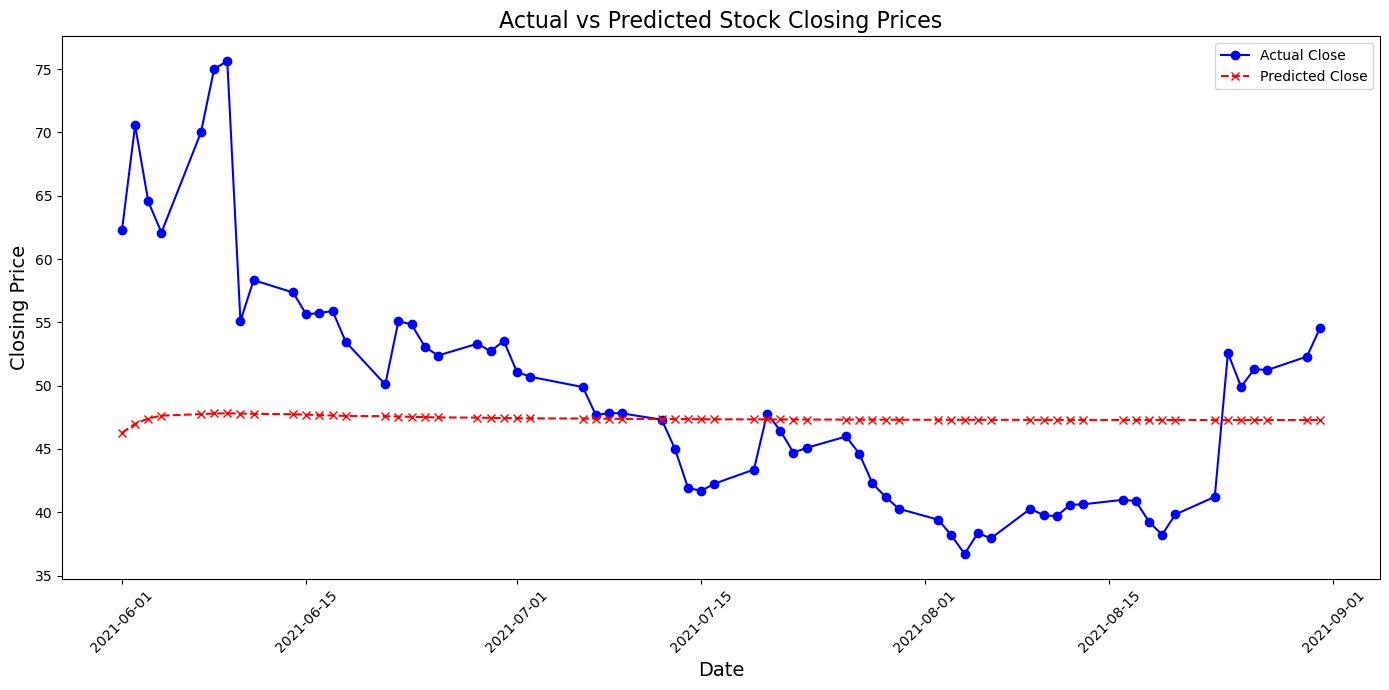

In [253]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [254]:
predictions_with_actuals_df.columns

Index(['Date', 'Predicted_Close', 'Actual_Close'], dtype='object')

In [255]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_test_original = predictions_with_actuals_df['Actual_Close']
predicted_prices_original = predictions_with_actuals_df['Predicted_Close']

mae = mean_absolute_error(y_test_original, predicted_prices_original)
mse = mean_squared_error(y_test_original, predicted_prices_original)
rmse = np.sqrt(mse)

#Source: https://www.freecodecamp.org/news/python-print-variable-how-to-print-a-string-and-variable/
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MAE: 7.160250311504657
MSE: 84.56712606928126
RMSE: 9.196038607426638


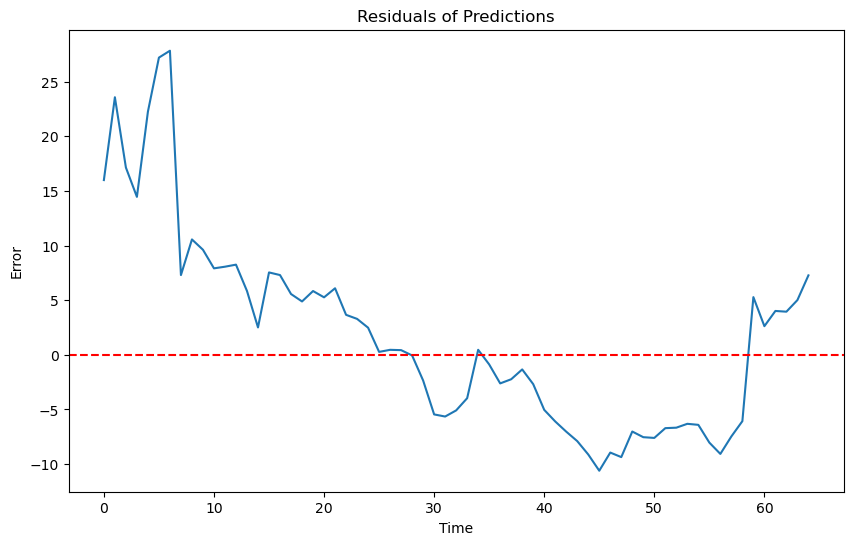

In [256]:
residuals = y_test_original - predicted_prices_original

plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of Predictions')
plt.xlabel('Time')
plt.ylabel('Error')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


##### Model with Rolling Averages

In [88]:
df_stock_rolling.head()

,Date,Open,High,Low,Volume,7 Day Rolling Avg,Close
0,2021-01-04,4.7500,4.7750,4.2875,40090000,4.594286,4.3125
1,2021-01-05,4.3375,4.5200,4.3075,19846000,4.594286,4.3425
2,2021-01-06,4.3350,4.7450,4.3325,24224800,4.594286,4.5900
3,2021-01-07,4.6175,4.8625,4.5050,24517200,4.594286,4.5200
4,2021-01-08,4.5450,4.5750,4.2700,25928000,4.594286,4.4225


In [89]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', '7 Day Rolling Avg']
features = df_stock_rolling[features].values

In [90]:
scaler2 = MinMaxScaler(feature_range=(0,1))
scaled_data2 = scaler2.fit_transform(features)

In [91]:
SEQUENCE_LENGTH = 30  # You can adjust this value -> parameter tuning
X, y = create_sequences(scaled_data2, SEQUENCE_LENGTH)

In [92]:
print(X.shape)
print(y.shape)

(222, 30, 6)
(222, 6)


In [93]:
# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = '2021-05-31'
train_indices = df_stock_rolling[df_stock_rolling['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]

In [94]:
print(X_train.shape, y_train.shape)

(71, 30, 6) (71, 6)


In [95]:
model2 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(30,6)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

In [96]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [97]:
model2.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
3/3 [==============================] - 2s 11ms/step - loss: 0.1095
Epoch 2/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0480
Epoch 3/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0538
Epoch 4/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0393
Epoch 5/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0423
Epoch 6/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0403
Epoch 7/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0371
Epoch 8/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0375
Epoch 9/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0370
Epoch 10/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0361
Epoch 11/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0358
Epoch 12/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0355
Epoch 13/20
3/3 [==============================] - 0s 11ms/step -

In [98]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),
                              periods=66, freq='B')

In [99]:
business_days

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-16', '2021-08-17',
      

In [100]:
#remove holiday, no stock data
business_days = business_days.drop('2021-07-05')

In [101]:
print(X_train[-1].shape)

(30, 6)


In [102]:
# Get the last sequence from the training data
#Source: https://stackoverflow.com/questions/69753424/keras-lstm-how-to-predict-beyond-validation-vs-predictions
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 6))

In [103]:
last_sequence.shape

(1, 30, 6)

In [104]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 50)            11400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 32901 (128.52 KB)
Trainable params: 32901 (128.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = model2.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

# Show the prediction results
print(predictions_df)

1/1 [==============================] - 0s 6ms/step
         Date  Predicted_Close
0  2021-06-01        39.137108
1  2021-06-02        39.500996
2  2021-06-03        39.262341
3  2021-06-04        38.922745
4  2021-06-07        38.383003
..        ...              ...
60 2021-08-25        38.372616
61 2021-08-26        38.714470
62 2021-08-27        38.521481
63 2021-08-30        38.266937
64 2021-08-31        37.833054

[65 rows x 2 columns]


In [106]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df_stock_rolling['Date'] = pd.to_datetime(df_stock_rolling['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df_stock_rolling[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        39.137108     62.255001
1  2021-06-02        39.500996     70.559998
2  2021-06-03        39.262341     64.544998
3  2021-06-04        38.922745     62.090000
4  2021-06-07        38.383003     70.002502
..        ...              ...           ...
60 2021-08-25        38.372616     49.912498
61 2021-08-26        38.714470     51.305000
62 2021-08-27        38.521481     51.237499
63 2021-08-30        38.266937     52.299999
64 2021-08-31        37.833054     54.560001

[65 rows x 3 columns]


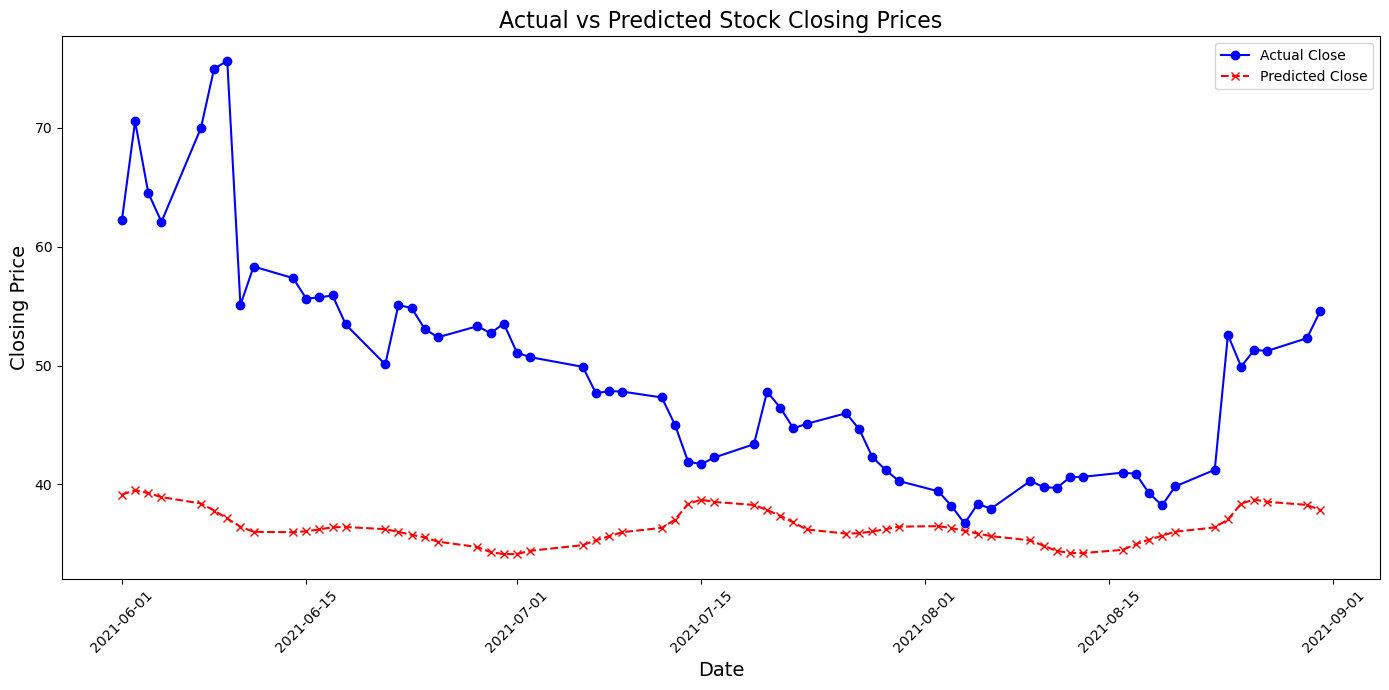

In [107]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [108]:
predictions_with_actuals_df.columns

Index(['Date', 'Predicted_Close', 'Actual_Close'], dtype='object')

In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_test_original2 = predictions_with_actuals_df['Actual_Close']
predicted_prices_original2 = predictions_with_actuals_df['Predicted_Close']

mae = mean_absolute_error(y_test_original2, predicted_prices_original2)
mse = mean_squared_error(y_test_original2, predicted_prices_original2)
rmse = np.sqrt(mse)

#Source: https://www.freecodecamp.org/news/python-print-variable-how-to-print-a-string-and-variable/
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 12.757949950961539
MSE: 237.15413353575127
RMSE: 15.39980952920364


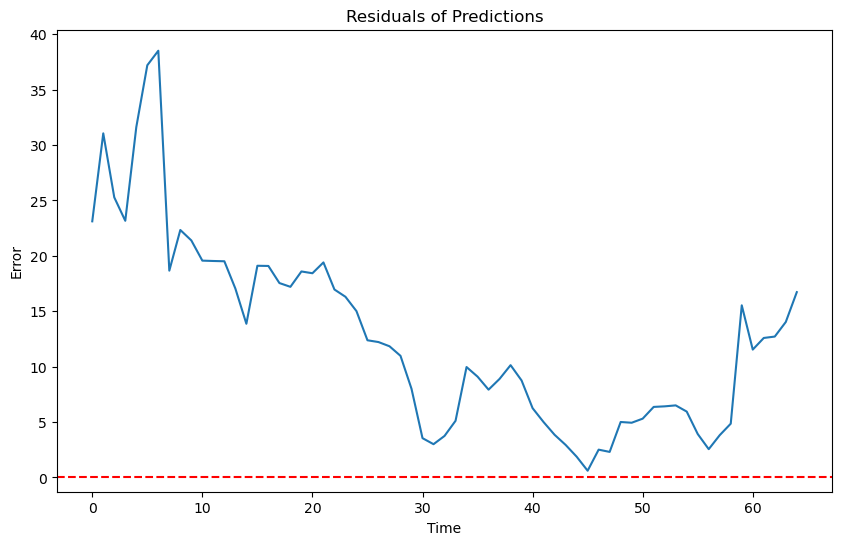

In [111]:
residuals = y_test_original2 - predicted_prices_original2

plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of Predictions')
plt.xlabel('Time')
plt.ylabel('Error')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


##### Training and Evaluating Stock and TDM Studio Sentiment

In [112]:
features2 = ['Close', 'Open', 'High', 'Low', 'Volume',
       '7 Day Rolling Avg', 'Anger', 'Disgust', 'Fear', 'Sadness', 'Happiness',
       'Love', 'Surprise', 'Neutral', 'Other']
features2 = df_merged1[features2].values

In [113]:
scaler3 = MinMaxScaler(feature_range=(0,1))
scaled_data3 = scaler3.fit_transform(features2)

In [114]:
SEQUENCE_LENGTH = 30  # You can adjust this value -> parameter tuning
X, y = create_sequences(scaled_data3, SEQUENCE_LENGTH)

In [115]:
print(X.shape)
print(y.shape)

(222, 30, 15)
(222, 15)


In [116]:
# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = '2021-05-31'
train_indices = df_merged1[df_merged1['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]

In [117]:
print(X_train.shape, y_train.shape)

(71, 30, 15) (71, 15)


In [118]:
model3 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(30,15)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

In [119]:
model3.compile(optimizer='adam', loss='mean_squared_error')

In [120]:
model3.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
3/3 [==============================] - 2s 10ms/step - loss: 0.2587
Epoch 2/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0613
Epoch 3/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0700
Epoch 4/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0388
Epoch 5/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0528
Epoch 6/20
3/3 [==============================] - 0s 13ms/step - loss: 0.0493
Epoch 7/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0388
Epoch 8/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0371
Epoch 9/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0406
Epoch 10/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0393
Epoch 11/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0366
Epoch 12/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0366
Epoch 13/20
3/3 [==============================] - 0s 9ms/step - lo

In [121]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),
                              periods=66, freq='B')

In [122]:
business_days

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-16', '2021-08-17',
      

In [123]:
#remove holiday, no stock data
business_days = business_days.drop('2021-07-05')

In [124]:
print(X_train[-1].shape)

(30, 15)


In [125]:
# Get the last sequence from the training data
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 15))

In [126]:
last_sequence.shape

(1, 30, 15)

In [127]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 50)            13200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 34701 (135.55 KB)
Trainable params: 34701 (135.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [128]:
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = model3.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

# Show the prediction results
print(predictions_df)

1/1 [==============================] - 0s 3ms/step
         Date  Predicted_Close
0  2021-06-01        38.443504
1  2021-06-02        38.705654
2  2021-06-03        38.832527
3  2021-06-04        38.749912
4  2021-06-07        38.556293
..        ...              ...
60 2021-08-25        38.247482
61 2021-08-26        38.537483
62 2021-08-27        38.706234
63 2021-08-30        38.670452
64 2021-08-31        38.521194

[65 rows x 2 columns]


In [129]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df_merged1['Date'] = pd.to_datetime(df_merged1['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df_merged1[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        38.443504     62.255001
1  2021-06-02        38.705654     70.559998
2  2021-06-03        38.832527     64.544998
3  2021-06-04        38.749912     62.090000
4  2021-06-07        38.556293     70.002502
..        ...              ...           ...
60 2021-08-25        38.247482     49.912498
61 2021-08-26        38.537483     51.305000
62 2021-08-27        38.706234     51.237499
63 2021-08-30        38.670452     52.299999
64 2021-08-31        38.521194     54.560001

[65 rows x 3 columns]


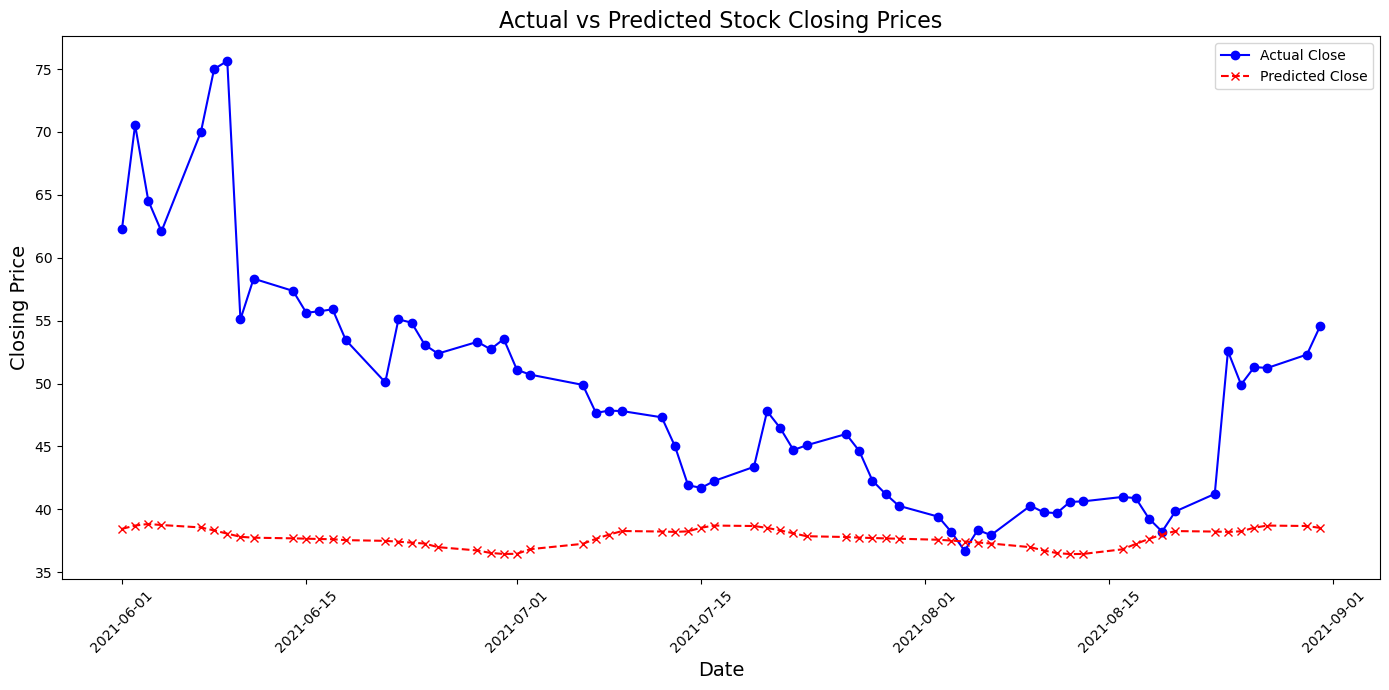

In [130]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [131]:
predictions_with_actuals_df.columns

Index(['Date', 'Predicted_Close', 'Actual_Close'], dtype='object')

In [132]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_test_original3 = predictions_with_actuals_df['Actual_Close']
predicted_prices_original3 = predictions_with_actuals_df['Predicted_Close']

mae = mean_absolute_error(y_test_original3, predicted_prices_original3)
mse = mean_squared_error(y_test_original3, predicted_prices_original3)
rmse = np.sqrt(mse)

#Source: https://www.freecodecamp.org/news/python-print-variable-how-to-print-a-string-and-variable/
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MAE: 11.43957883113732
MSE: 209.84006120615666
RMSE: 14.485857282403298


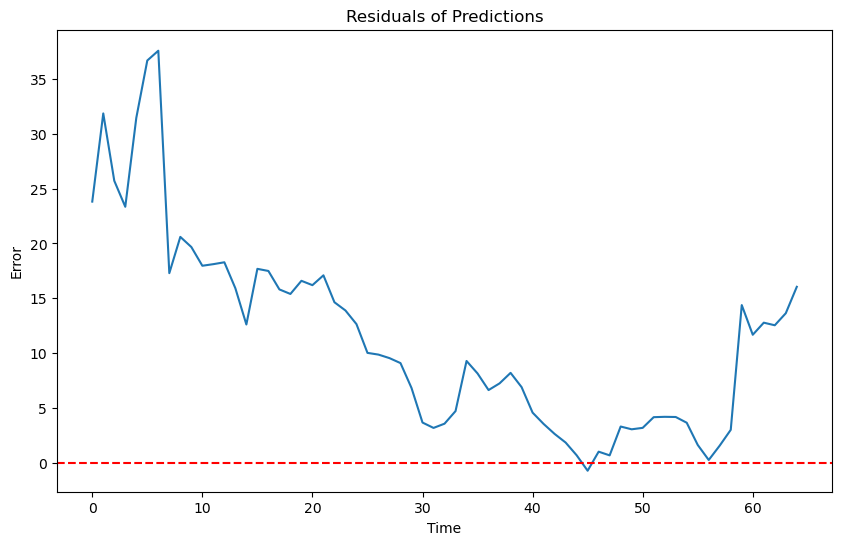

In [134]:
residuals = y_test_original3 - predicted_prices_original3

plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of Predictions')
plt.xlabel('Time')
plt.ylabel('Error')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


#### Training and Evaluating Stock and Google News Sentiment

In [135]:
column_to_move = df_join_stock_news.pop('Close')

In [136]:
df_join_stock_news.loc[:, 'Close'] = column_to_move

In [137]:
df_join_stock_news.columns

Index(['Date', 'Open', 'High', 'Low', 'Volume', '7 Day Rolling Avg',
       'compound', 'Close'],
      dtype='object')

In [138]:
features3 = ['Close', 'Open', 'High', 'Low', 'Volume',
       '7 Day Rolling Avg', 'compound']
features3 = df_join_stock_news[features3].values

In [139]:
scaler4 = MinMaxScaler(feature_range=(0,1))
scaled_data4 = scaler4.fit_transform(features3)

In [140]:
SEQUENCE_LENGTH = 30  # You can adjust this value -> parameter tuning
X, y = create_sequences(scaled_data4, SEQUENCE_LENGTH)

In [141]:
print(X.shape)
print(y.shape)

(222, 30, 7)
(222, 7)


In [142]:
# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = '2021-05-31'
train_indices = df_join_stock_news[df_join_stock_news['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]

In [143]:
print(X_train.shape, y_train.shape)

(71, 30, 7) (71, 7)


In [144]:
model4 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(30,7)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

In [145]:
model4.compile(optimizer='adam', loss='mean_squared_error')

In [146]:
model4.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
3/3 [==============================] - 2s 14ms/step - loss: 0.0993
Epoch 2/20
3/3 [==============================] - 0s 12ms/step - loss: 0.0659
Epoch 3/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0408
Epoch 4/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0430
Epoch 5/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0440
Epoch 6/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0372
Epoch 7/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0368
Epoch 8/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0371
Epoch 9/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0351
Epoch 10/20
3/3 [==============================] - 0s 12ms/step - loss: 0.0349
Epoch 11/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0349
Epoch 12/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0341
Epoch 13/20
3/3 [==============================] - 0s 10ms/step

In [147]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),
                              periods=66, freq='B')

In [148]:
business_days

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-16', '2021-08-17',
      

In [149]:
#remove holiday, no stock data
business_days = business_days.drop('2021-07-05')

In [150]:
print(X_train[-1].shape)

(30, 7)


In [151]:
# Get the last sequence from the training data
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 7))

In [152]:
last_sequence.shape

(1, 30, 7)

In [153]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 50)            11600     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 33101 (129.30 KB)
Trainable params: 33101 (129.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [154]:
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = model4.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

# Show the prediction results
print(predictions_df)

1/1 [==============================] - 0s 5ms/step
         Date  Predicted_Close
0  2021-06-01        38.020325
1  2021-06-02        38.419910
2  2021-06-03        38.329887
3  2021-06-04        38.130695
4  2021-06-07        37.739433
..        ...              ...
60 2021-08-25        37.085567
61 2021-08-26        37.441963
62 2021-08-27        37.389393
63 2021-08-30        37.274044
64 2021-08-31        36.980026

[65 rows x 2 columns]


In [155]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df_join_stock_news['Date'] = pd.to_datetime(df_join_stock_news['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df_join_stock_news[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        38.020325     62.255001
1  2021-06-02        38.419910     70.559998
2  2021-06-03        38.329887     64.544998
3  2021-06-04        38.130695     62.090000
4  2021-06-07        37.739433     70.002502
..        ...              ...           ...
60 2021-08-25        37.085567     49.912498
61 2021-08-26        37.441963     51.305000
62 2021-08-27        37.389393     51.237499
63 2021-08-30        37.274044     52.299999
64 2021-08-31        36.980026     54.560001

[65 rows x 3 columns]


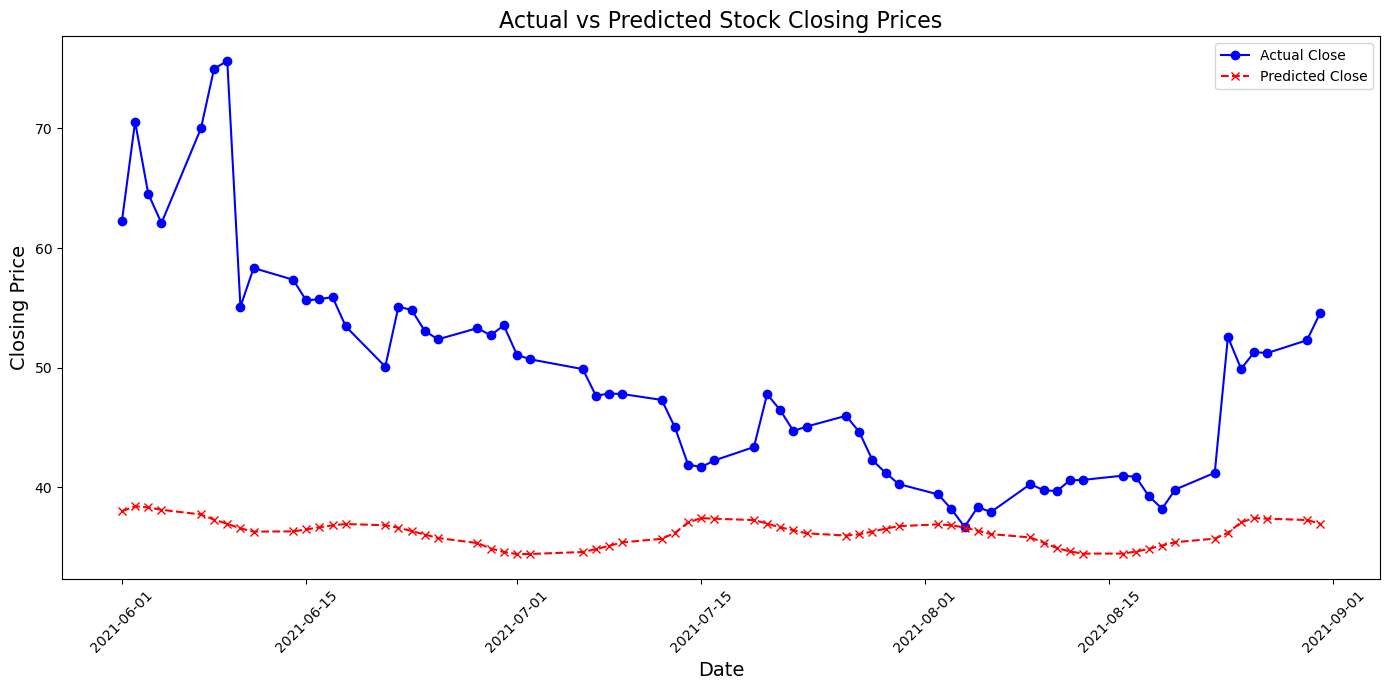

In [156]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [157]:
predictions_with_actuals_df.columns

Index(['Date', 'Predicted_Close', 'Actual_Close'], dtype='object')

In [158]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_test_original4 = predictions_with_actuals_df['Actual_Close']
predicted_prices_original4 = predictions_with_actuals_df['Predicted_Close']

mae = mean_absolute_error(y_test_original4, predicted_prices_original4)
mse = mean_squared_error(y_test_original4, predicted_prices_original4)
rmse = np.sqrt(mse)

#Source: https://www.freecodecamp.org/news/python-print-variable-how-to-print-a-string-and-variable/
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MAE: 12.912937462229568
MSE: 242.07899257664513
RMSE: 15.558887896525418


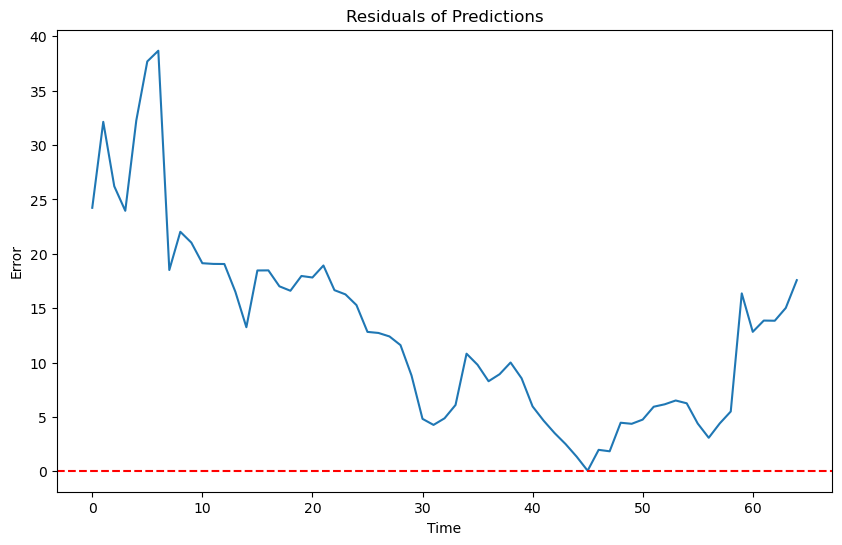

In [160]:
residuals = y_test_original4 - predicted_prices_original4

plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of Predictions')
plt.xlabel('Time')
plt.ylabel('Error')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


#### Training and Evaluating Model with Stock Data and Sentiment from rGME

In [161]:
column_to_remove = df_rGME_sentiment_stock.pop('Close')

In [162]:
df_rGME_sentiment_stock.loc[:, 'Close'] = column_to_remove

In [163]:
df_rGME_sentiment_stock.columns

Index(['Date', 'Open', 'High', 'Low', 'Volume', '7 Day Rolling Avg',
       'compound', 'Close'],
      dtype='object')

In [164]:
features4 = ['Open', 'High', 'Low', 'Volume', '7 Day Rolling Avg',
       'compound', 'Close']
features4 = df_rGME_sentiment_stock[features4].values

In [165]:
scaler5 = MinMaxScaler(feature_range=(0,1))
scaled_data5 = scaler5.fit_transform(features4)

In [166]:
SEQUENCE_LENGTH = 30  # You can adjust this value -> parameter tuning
X, y = create_sequences(scaled_data5, SEQUENCE_LENGTH)

In [167]:
print(X.shape)
print(y.shape)

(222, 30, 7)
(222, 7)


In [168]:
# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = '2021-05-31'
train_indices = df_rGME_sentiment_stock[df_rGME_sentiment_stock['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]

In [169]:
print(X_train.shape, y_train.shape)

(71, 30, 7) (71, 7)


In [170]:
model5 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(30,7)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

In [171]:
model5.compile(optimizer='adam', loss='mean_squared_error')

In [172]:
model5.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
3/3 [==============================] - 2s 11ms/step - loss: 0.1177
Epoch 2/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0642
Epoch 3/20
3/3 [==============================] - 0s 12ms/step - loss: 0.0526
Epoch 4/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0404
Epoch 5/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0479
Epoch 6/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0460
Epoch 7/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0391
Epoch 8/20
3/3 [==============================] - 0s 16ms/step - loss: 0.0374
Epoch 9/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0398
Epoch 10/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0390
Epoch 11/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0362
Epoch 12/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0364
Epoch 13/20
3/3 [==============================] - 0s 10ms/step

In [173]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),
                              periods=66, freq='B')

In [174]:
business_days

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-16', '2021-08-17',
      

In [175]:
#remove holiday, no stock data
business_days = business_days.drop('2021-07-05')

In [176]:
print(X_train[-1].shape)

(30, 7)


In [177]:
# Get the last sequence from the training data
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 7))

In [178]:
last_sequence.shape

(1, 30, 7)

In [179]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 50)            11600     
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 25)                1275      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 33101 (129.30 KB)
Trainable params: 33101 (129.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [180]:
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = model5.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

# Show the prediction results
print(predictions_df)

1/1 [==============================] - 0s 15ms/step
         Date  Predicted_Close
0  2021-06-01        36.232971
1  2021-06-02        36.373337
2  2021-06-03        36.183697
3  2021-06-04        35.906578
4  2021-06-07        35.535484
..        ...              ...
60 2021-08-25        35.753616
61 2021-08-26        35.904320
62 2021-08-27        35.764153
63 2021-08-30        35.558056
64 2021-08-31        35.263565

[65 rows x 2 columns]


In [181]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df_rGME_sentiment_stock['Date'] = pd.to_datetime(df_rGME_sentiment_stock['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df_rGME_sentiment_stock[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        36.232971     62.255001
1  2021-06-02        36.373337     70.559998
2  2021-06-03        36.183697     64.544998
3  2021-06-04        35.906578     62.090000
4  2021-06-07        35.535484     70.002502
..        ...              ...           ...
60 2021-08-25        35.753616     49.912498
61 2021-08-26        35.904320     51.305000
62 2021-08-27        35.764153     51.237499
63 2021-08-30        35.558056     52.299999
64 2021-08-31        35.263565     54.560001

[65 rows x 3 columns]


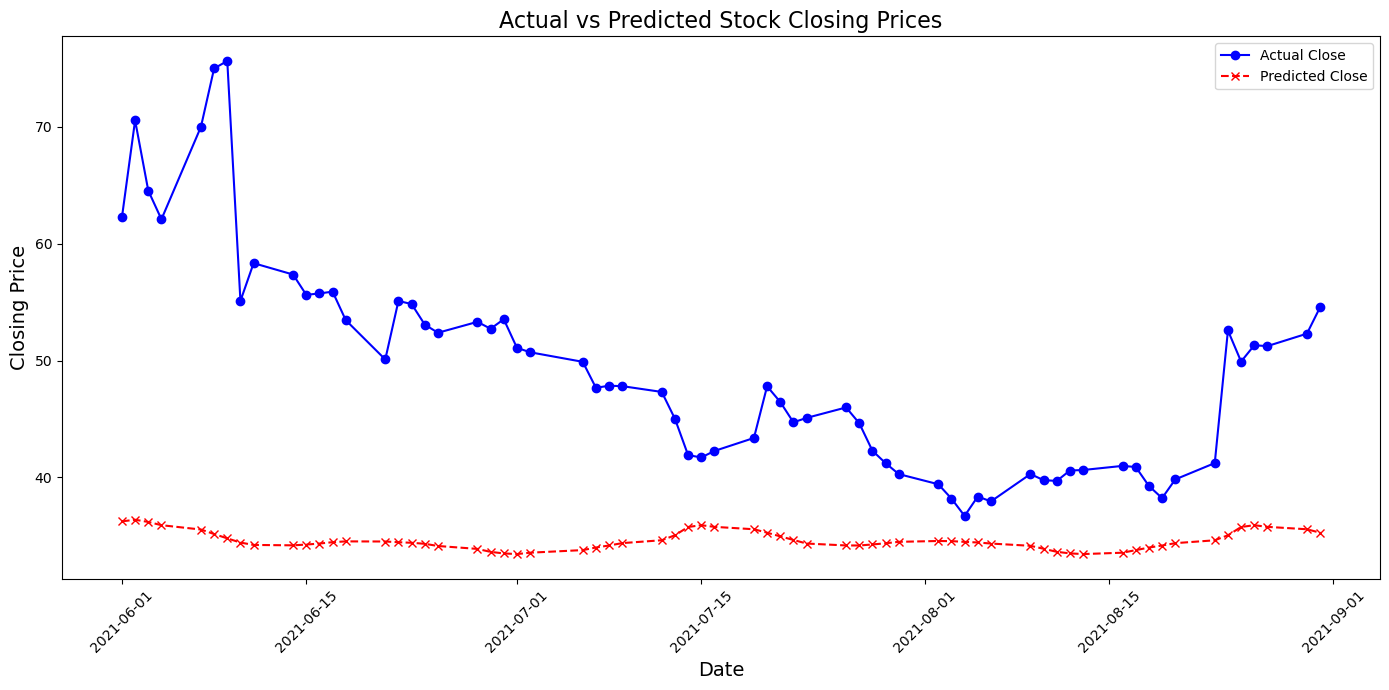

In [182]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [183]:
predictions_with_actuals_df.columns

Index(['Date', 'Predicted_Close', 'Actual_Close'], dtype='object')

In [184]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_test_original5 = predictions_with_actuals_df['Actual_Close']
predicted_prices_original5 = predictions_with_actuals_df['Predicted_Close']

mae = mean_absolute_error(y_test_original5, predicted_prices_original5)
mse = mean_squared_error(y_test_original5, predicted_prices_original5)
rmse = np.sqrt(mse)

#Source: https://www.freecodecamp.org/news/python-print-variable-how-to-print-a-string-and-variable/
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MAE: 14.568529691045674
MSE: 290.39583430628755
RMSE: 17.04100449815936


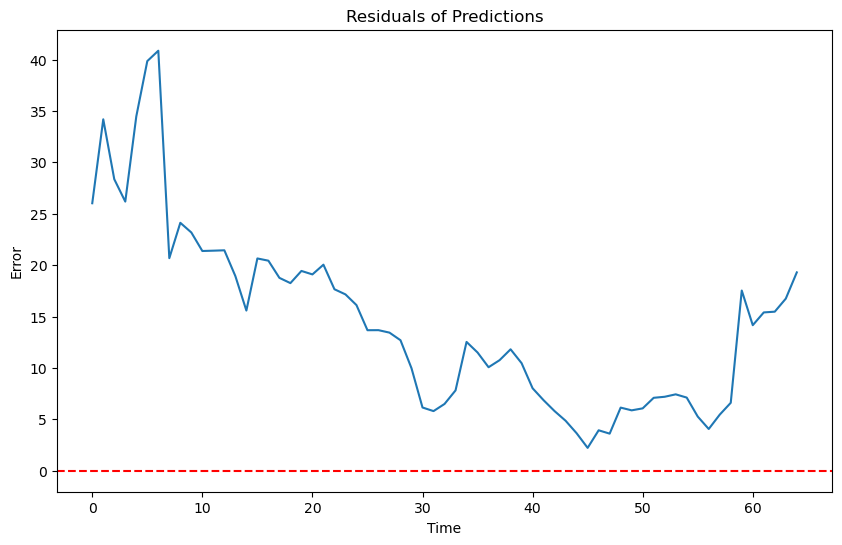

In [186]:
residuals = y_test_original5 - predicted_prices_original5

plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of Predictions')
plt.xlabel('Time')
plt.ylabel('Error')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


#### Transformer Model

**** The Transformer elements of the code below were entirely generated by ChatGPT with small edits by me to ensure that the input dimensions at various stages were correct for the data utilized. See Appendix section below for detailed query.

In [187]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam


In [294]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(dense_dim, activation="relu"), Dense(16),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(0.1)
        self.dropout2 = Dropout(0.1)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [189]:
def build_model(input_shape, num_heads, embed_dim, dense_dim):
    inputs = Input(shape=input_shape)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(inputs)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    return model


In [190]:
df_TDM_sentiment = df_merged1[['Anger',
       'Disgust', 'Fear', 'Sadness', 'Happiness', 'Love', 'Surprise',
       'Neutral', 'Other']].copy()
df_rGME_sentiment_stock = df_rGME_sentiment_stock.join(df_TDM_sentiment)
df_rGME_sentiment_stock.columns

Index(['Date', 'Open', 'High', 'Low', 'Volume', '7 Day Rolling Avg',
       'compound', 'Close', 'Anger', 'Disgust', 'Fear', 'Sadness', 'Happiness',
       'Love', 'Surprise', 'Neutral', 'Other'],
      dtype='object')

In [191]:
column_to_move = df_rGME_sentiment_stock.pop('Close')
df_rGME_sentiment_stock.loc[:, 'Close'] = column_to_remove
df_rGME_sentiment_stock.columns

Index(['Date', 'Open', 'High', 'Low', 'Volume', '7 Day Rolling Avg',
       'compound', 'Anger', 'Disgust', 'Fear', 'Sadness', 'Happiness', 'Love',
       'Surprise', 'Neutral', 'Other', 'Close'],
      dtype='object')

In [295]:
features5 = ['Open', 'High', 'Low', 'Volume', '7 Day Rolling Avg',
             'compound', 'Anger', 'Disgust', 'Fear', 'Sadness',
             'Happiness', 'Love', 'Surprise', 'Neutral', 'Other', 'Close']
features5 = df_rGME_sentiment_stock[features5].values

In [296]:
scaler6 = MinMaxScaler(feature_range=(0,1))
scaled_data6 = scaler5.fit_transform(features5)
sequence_length = 30

In [297]:
X, y = create_sequences(scaled_data6, sequence_length)

In [298]:
print(X.shape, y.shape)

(222, 30, 16) (222, 16)


In [299]:
sequence_length=30
num_features=16

In [300]:
# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = '2021-05-31'
train_indices = df_rGME_sentiment_stock[df_rGME_sentiment_stock['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]

In [301]:
print(X_train.shape, y_train.shape)

(71, 30, 16) (71, 16)


In [315]:
# Transformer Model with Stock, rGME, and TDM Studio Sentiment
model6 = load_model('transformer_model')

In [316]:
# input_shape = (sequence_length, num_features)  # Adjust based on your data
# embed_dim = 32  # Embedding size for each token
# num_heads = 2  # Number of attention heads
# dense_dim = 32  # Hidden layer size in feed forward network inside transformer

# model6 = build_model(input_shape, num_heads, embed_dim, dense_dim)
# model6.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

# # Assuming X_train and y_train are prepared
# history = model6.fit(X_train, y_train, batch_size=32, epochs=200, validation_split=0.2)


In [317]:
# Get the last sequence from the training data
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 16))

In [318]:
last_sequence.shape

(1, 30, 16)

In [319]:
model6.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 30, 16)]          0         
                                                                 
 transformer_encoder_9 (Tra  (None, 30, 16)            5440      
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d_9  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_29 (Dropout)        (None, 16)                0         
                                                                 
 dense_43 (Dense)            (None, 1)                 17        
                                                                 
Total params: 5457 (21.32 KB)
Trainable params: 5457 (21.32

In [320]:
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = model6.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

# Show the prediction results
print(predictions_df)

1/1 [==============================] - 0s 9ms/step
         Date  Predicted_Close
0  2021-06-01        63.873001
1  2021-06-02        63.272945
2  2021-06-03        62.722889
3  2021-06-04        61.957756
4  2021-06-07        61.203217
..        ...              ...
60 2021-08-25        53.311859
61 2021-08-26        53.224651
62 2021-08-27        53.150856
63 2021-08-30        53.087570
64 2021-08-31        53.042023

[65 rows x 2 columns]


In [321]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df_rGME_sentiment_stock['Date'] = pd.to_datetime(df_rGME_sentiment_stock['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df_rGME_sentiment_stock[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        63.873001     62.255001
1  2021-06-02        63.272945     70.559998
2  2021-06-03        62.722889     64.544998
3  2021-06-04        61.957756     62.090000
4  2021-06-07        61.203217     70.002502
..        ...              ...           ...
60 2021-08-25        53.311859     49.912498
61 2021-08-26        53.224651     51.305000
62 2021-08-27        53.150856     51.237499
63 2021-08-30        53.087570     52.299999
64 2021-08-31        53.042023     54.560001

[65 rows x 3 columns]


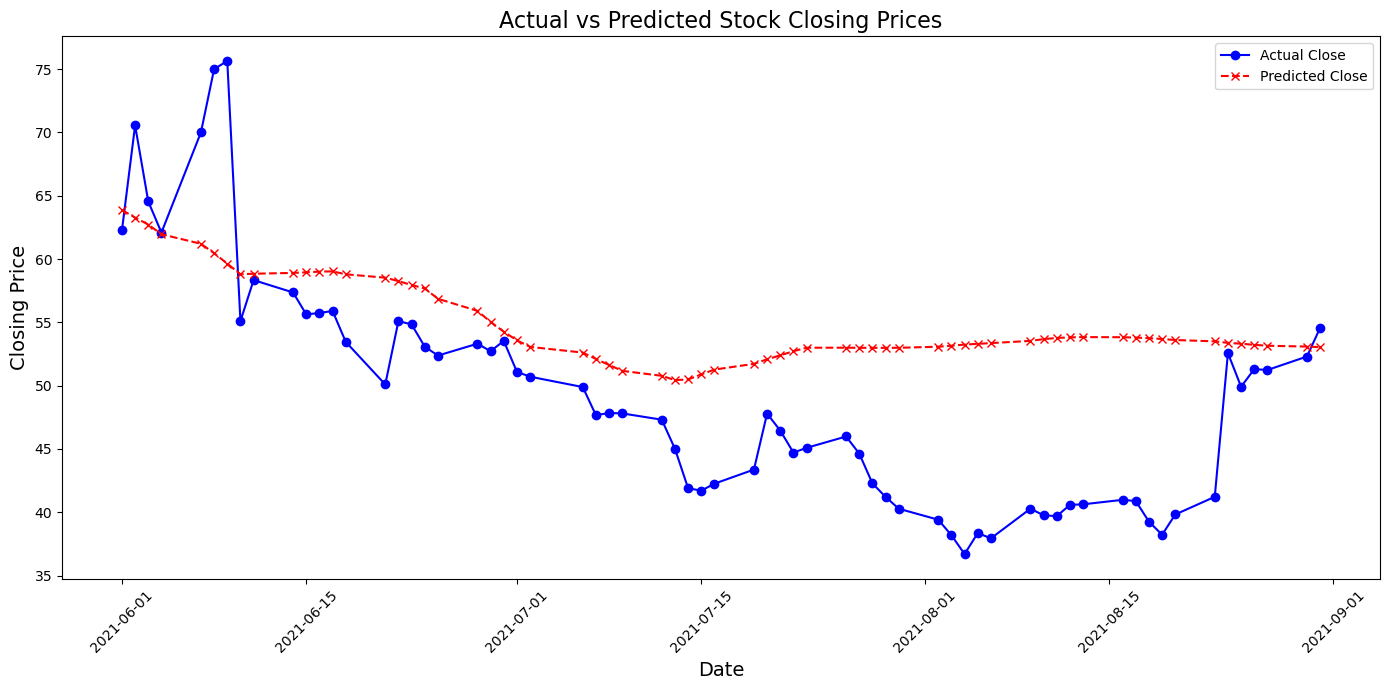

In [322]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [323]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_test_original6 = predictions_with_actuals_df['Actual_Close']
predicted_prices_original6 = predictions_with_actuals_df['Predicted_Close']

mae = mean_absolute_error(y_test_original6, predicted_prices_original6)
mse = mean_squared_error(y_test_original6, predicted_prices_original6)
rmse = np.sqrt(mse)

#Source: https://www.freecodecamp.org/news/python-print-variable-how-to-print-a-string-and-variable/
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MAE: 7.316627875401893
MSE: 79.36796540827848
RMSE: 8.90887004104777


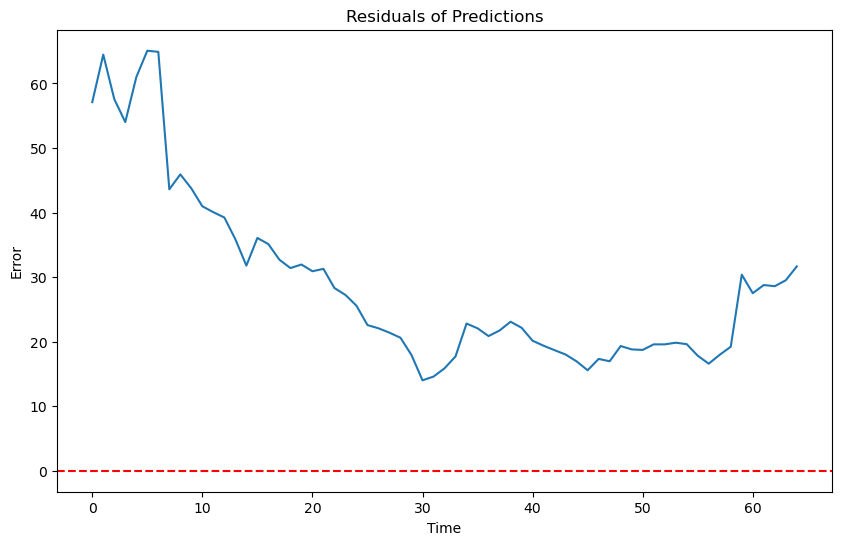

In [208]:
residuals = y_test_original6 - predicted_prices_original6

plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of Predictions')
plt.xlabel('Time')
plt.ylabel('Error')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


#### Saving Initial Models

In [312]:
# # Assuming 'model' is your Keras model
# model6.save('transformer_model')
# model.save('stock_model')
# model2.save('stock_rolling_model')
# model3.save('stock_tdm_model')
# model4.save('stock_google_model')
# model5.save('stock_rGME_model')

INFO:tensorflow:Assets written to: transformer_model\assets


INFO:tensorflow:Assets written to: transformer_model\assets


#### Load Models for Comparison

In [210]:
# # Stock only model
# model = load_model('stock_model')

# # Stock with 7 Day Rolling Average
# model2 = load_model('stock_rolling_model')

# # Stock with TDM Studio Sentiment
# model3 = load_model('stock_tdm_model')

# # Stock with Scraped Google News Headlines
# model4 = load_model('stock_google_model')

# # Stock with rGME Sentiment
# model5 = load_model('stock_rGME_model')

# # Transformer Model with Stock, rGME, and TDM Studio Sentiment
# model6 = load_model('transformer_model')

In [211]:
def model_evaluation(y_test, predictions):
    '''
    Function to easily display the evaluation metrics of each model
    '''
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)

    #Source: https://www.freecodecamp.org/news/python-print-variable-how-to-print-a-string-and-variable/
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print()

In [324]:
# Stock only model
print("Stock only model: ")
model_evaluation(y_test=y_test_original, predictions=predicted_prices_original)

print()
print("***Note: all of the following models utilize the 7 Day Rolling Average")
print()
# Stock with 7 Day Rolling Average
print("Stock with 7 Day Rolling Average model: ")
model_evaluation(y_test=y_test_original2, predictions=predicted_prices_original2)

# Stock with TDM Studio Sentiment
print("Stock with TDM Studio Sentiment data: ")
model_evaluation(y_test=y_test_original3, predictions=predicted_prices_original3)

# Stock with Scraped Google News Headlines
print("Stock with scraped Google News Headlines: " )
model_evaluation(y_test=y_test_original4, predictions=predicted_prices_original4)

# Stock with rGME Sentiment
print("Stock with rGME Compound Sentiment scores: ")
model_evaluation(y_test=y_test_original5, predictions=predicted_prices_original5)

# Transformer Model with Stock, rGME, and TDM Studio Sentiment
print("Transformer Model with Stock, rGME, and TDM Studio Sentiment data: ")
model_evaluation(y_test=y_test_original6, predictions=predicted_prices_original6)

Stock only model: 
MAE: 7.160250311504657
MSE: 84.56712606928126
RMSE: 9.196038607426638


***Note: all of the following models utilize the 7 Day Rolling Average

Stock with 7 Day Rolling Average model: 
MAE: 12.757949950961539
MSE: 237.15413353575127
RMSE: 15.39980952920364

Stock with TDM Studio Sentiment data: 
MAE: 11.43957883113732
MSE: 209.84006120615666
RMSE: 14.485857282403298

Stock with scraped Google News Headlines: 
MAE: 12.912937462229568
MSE: 242.07899257664513
RMSE: 15.558887896525418

Stock with rGME Compound Sentiment scores: 
MAE: 14.568529691045674
MSE: 290.39583430628755
RMSE: 17.04100449815936

Transformer Model with Stock, rGME, and TDM Studio Sentiment data: 
MAE: 7.316627875401893
MSE: 79.36796540827848
RMSE: 8.90887004104777



### Appendix A - AI Prompts and Responses

#### How might I use VADER to then perform sentiment analysis on my data?

Query driven by visit to source: https://realpython.com/python-nltk-sentiment-analysis/

To perform sentiment analysis using VADER (Valence Aware Dictionary and sEntiment Reasoner) on your data in a Pandas DataFrame, you'll need to follow these steps:

Step 1: Install VADER
VADER is included in the nltk (Natural Language Toolkit) package. If you haven't installed NLTK, you can do so via pip. You also need to download the VADER lexicon.

bash
Copy code
pip install nltk
In your Python script, download the VADER lexicon:

python
Copy code
import nltk
nltk.download('vader_lexicon')
Step 2: Import and Initialize VADER Sentiment Analyzer
python
Copy code
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
Step 3: Apply Sentiment Analysis to DataFrame
Assuming you have a DataFrame df with a text column (e.g., 'Text'), you can apply VADER to perform sentiment analysis:

python
Copy code
import pandas as pd

Example DataFrame
data = {'Text': ['I love sunny days in New York.', 'The movie was terrible and boring.']}
df = pd.DataFrame(data)

Function to get sentiment
def get_sentiment(text):
    return sia.polarity_scores(text)

Apply the function to the DataFrame
df['Sentiment'] = df['Text'].apply(get_sentiment)

Display the DataFrame
print(df)
This script will create a new column in your DataFrame called 'Sentiment', where each row contains a dictionary with scores for each of the four categories in VADER: 'neg' for negative, 'neu' for neutral, 'pos' for positive, and 'compound' for the aggregated score.

#### **If I have two date values for a start and end date, how would I get all of the values in between them? For example, if I have 2015-11-16 to 2015-11-22?

In [213]:
# from datetime import datetime, timedelta

# # Start and end dates
# start_date = datetime.strptime("2015-11-16", "%Y-%m-%d")
# end_date = datetime.strptime("2015-11-22", "%Y-%m-%d")

# # Generate all dates between start and end date
# date_generated = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days + 1)]

# # Convert to strings if needed
# date_strings = [date.strftime("%Y-%m-%d") for date in date_generated]

# date_strings

#### ****What would be a simple Transformer model to implement for analysis of stock data and sentiment data? All of the data is already numeric in a dataframe.

For a simple Transformer model applied to stock and sentiment data, you can start with a basic architecture that includes an embedding layer (if necessary), Transformer encoder layers, and a final dense layer for prediction. Since your data is numeric and structured, you might skip the embedding layer or use it to project numeric features into a higher-dimensional space, depending on the complexity of your task.

Here's a basic outline of what such a Transformer model could look like using TensorFlow and Keras. This example assumes you're working on a regression task, such as predicting future stock prices:

Step 1: Import Necessary Libraries
python
Copy code
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
Step 2: Define Transformer Block
A Transformer block consists of multi-head self-attention and position-wise feed-forward networks, along with layer normalization.

python
Copy code
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(dense_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(0.1)
        self.dropout2 = Dropout(0.1)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
Step 3: Build the Model
Assemble the Transformer model. This example builds a model that takes sequences of stock and sentiment data as input.

python
Copy code
def build_model(input_shape, num_heads, embed_dim, dense_dim):
    inputs = Input(shape=input_shape)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(inputs)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    return model
Step 4: Compile and Train the Model
Compile and train your model. Adjust the learning rate, batch size, and number of epochs as necessary.

python
Copy code
input_shape = (sequence_length, num_features)  # Adjust based on your data
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
dense_dim = 32  # Hidden layer size in feed forward network inside transformer

model = build_model(input_shape, num_heads, embed_dim, dense_dim)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

# Assuming X_train and y_train are prepared
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2)
Notes
Input Shape: Adjust input_shape to match your data. It should be (sequence_length, num_features), where sequence_length is the number of time steps you're including in each sample, and num_features includes both stock and sentiment features.
Feature Engineering: Even though the Transformer model can capture complex dependencies, thoughtful feature engineering can significantly impact model performance. Consider including lagged stock features, moving averages, and sentiment scores as part of your feature set.
Hyperparameters: The model's performance can be sensitive to the choice of hyperparameters, including the number of attention heads, the dimensionality of the Transformer, and the learning rate. Experiment with different configurations to find the best setup for your specific dataset.
This simple Transformer model provides a starting point for analyzing stock and sentiment data. Depending on your task's complexity and dataset size, you may need to adjust the model architecture, depth, and training parameters.